In [1]:
import matplotlib.pyplot as plt
import os
from project_classes import *
from functions import *
from iceflow_library import *
from scipy.optimize import curve_fit
import scipy.optimize as opt
import sys

In [2]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8"
# season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
# that flight only has one point
flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
# one dimensional data error
# TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
# plots fake crossovers along the curved path
# flight = "20161024_05"
# flight = "20161111_05"
# probably too close to the coast to be useful
# flight = "20161024_05"
# flight = "20141026_06"
flight = "20230127_01"
# ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

In [3]:
# print(f"Force remaking {file_name}...")
# mat_pickler_h5py(season, flight, testing_mode=testing, convert_xy=True)  # make it
# layers = read_layers(file_name)  # read in the layers from the pickle file
# print(f"File {file_name} created.")
# 
# # if not os.path.isfile(
# #         "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle"):  # if the file does not exist
# #     print("The iceflow data pickle file was not found. Creating a new one...")
# #     filename = iceflow_saver()
# #     iceflow_data = iceflow_loader(filename)
# #     print("The iceflow data pickle file was successfully created.")
# # # try:
# # iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle")
# # print("The iceflow data pickle file was found and loaded.")
# # 
# # x = iceflow_data[0]
# # y = iceflow_data[1]
# # velocity_x = iceflow_data[2]
# # velocity_y = iceflow_data[3]
# # latitude = iceflow_data[4]
# # longitude = iceflow_data[5]
# # print("iceflow data loaded")
# 
# 
# print(f"Force remaking {file_name}...")

if not os.path.isfile(file_name):  # if the file does not exist
    print(f"File {file_name} does not exist. Making it...")
    mat_pickler_h5py(season, flight, testing_mode=testing, convert_xy=True)  # make it
    layers = read_layers(file_name)  # read in the layers from the pickle file
    print(f"File {file_name} created.")
else:
    layers = read_layers(file_name)  # read in the layers from the pickle file
    print(f"File {file_name} loaded.")

filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"


Reading pickle file...
--------------------
Surface
Bottom
--------------------

File C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle loaded.


In [4]:
# intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
# with open(filename, 'wb') as file:
#     pickle.dump(intersection_indices, file)
#     pickle.dump(intersection_points, file)
#     pickle.dump(segment_ends, file)
# print(f"intersection_indices and intersection_points saved to {filename}")

force_redo_intersections = False
filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename) or force_redo_intersections:  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

intersection_indices and intersection_points loaded from C:\Users\rj\Documents\cresis_project\pickle_jar\2022_Antarctica_BaslerMKB_20230127_01_crossover_points.pickle


In [5]:
import matplotlib.animation as animation
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

point: nan is not 0. Hopefully it is nan.
point: nan is not 0. Hopefully it is nan.


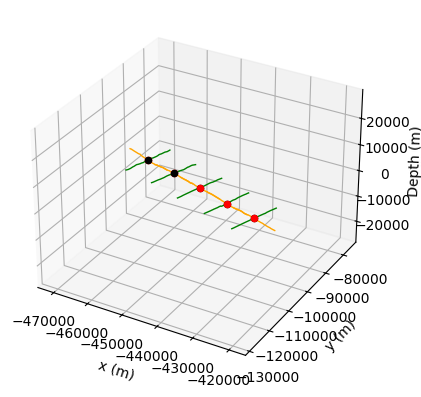

In [8]:
def plot_layers_3d_xy(layers, season, flight, intersect_indices, seg_ends):
    # plot the layers with respect to lat, lon, and twtt
    # plot a grid of scattered points at 0 twtt to represent the surface

    # convert the lat-lon points to xy points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot_all = False
    # plot_all = True
    plot_surface = False
    # plot_surface = True

    for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

    for point in layers[0].twtt_corrected:
        if point != 0:
            print(f"point: {point} is not 0. Hopefully it is nan.")

    x_bottom = []
    y_bottom = []
    twtts_bottom = []
    depth_bottom = []
    x_surf = []
    y_surf = []
    twtts_surf = []
    depth_surf = []

    for i in range(len(layers[0].lat)):
        x_surf.append(layers[0].x[i])
        y_surf.append(layers[0].y[i])
        twtts_surf.append(layers[0].twtt_corrected[i])
        depth_surf.append(layers[0].depth[i])
        # if layers[1].lat[i] is not nan
        if not np.isnan(layers[1].lat[i]):
            x_bottom.append(layers[1].x[i])
            y_bottom.append(layers[1].y[i])
            twtts_bottom.append(layers[1].twtt_corrected[i])
            depth_bottom.append(layers[1].depth[i])

    offset = 500
    # offset_max = 500

    i = 0
    # for index in range(len(intersect_indices) - 1):

    if plot_surface:
        # plot the surface layer (layer 0)
        ax.plot(x_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                y_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                [-x for x in (depth_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset])],
                label='top. seg. 1', c='grey',
                linewidth=1)

        ax.plot(x_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                y_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                [-x for x in (depth_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset])],
                label='top seg. 2', c='grey',
                linewidth=1)

    loop_range = len(intersection_indices) - 1
    # loop_range = 1

    # def animate(offset):
    for index in range(loop_range):
        start_index_seg1 = intersect_indices[index][1] - offset
        end_index_seg2 = intersect_indices[index][1] + offset

        start_index_seg2 = intersect_indices[index][0] - offset
        end_index_seg1 = intersect_indices[index][0] + offset

        ax.plot(x_bottom[start_index_seg1:end_index_seg2],
                y_bottom[start_index_seg1:end_index_seg2],
                [-x for x in depth_bottom[start_index_seg1:end_index_seg2]],
                label='bott. seg. 2', c='green', linewidth=1)

        ax.plot(x_bottom[start_index_seg2:end_index_seg1],
                y_bottom[start_index_seg2:end_index_seg1],
                [-x for x in depth_bottom[start_index_seg2:end_index_seg1]],
                label='bott. seg. 1', c='orange', linewidth=1)

        # for index in range(loop_range):
        ax.scatter(layers[1].x[intersect_indices[index][0]],
                   layers[1].y[intersect_indices[index][0]],
                   -1 * layers[1].depth[intersect_indices[index][0]],
                   c='red', marker='o')
        ax.scatter(layers[1].x[intersect_indices[index][1]],
                   layers[1].y[intersect_indices[index][1]],
                   -1 * layers[1].depth[intersect_indices[index][1]],
                   c='black', marker='o')

    # plot all the points in layers[1]
    if plot_all:
        ax.plot(x_bottom, y_bottom, [-x for x in depth_bottom], label='bottom', c='grey', linewidth=0.1)



        # set x limits to the min and max of the x values times 1.1
    # ax.set_xlim(min(x_surf) * 1.1, max(x_surf) * 1.1)
    # set y limits to the min and max of the y values times 1.1
    # ax.set_ylim(min(y_surf) * 1.1, max(y_surf) * 1.1)

    # for offset in range(0, int(offset_max/10)):
    #     sys.stdout.write('\r')
    #     sys.stdout.write(f"loop {offset}\033[0m")
    #     sys.stdout.flush()  # flush the buffer
    #     # animate(offset * 10)

    # invert the z axis
    ax.invert_zaxis()

    # add a legend without the whole bottom and whole surface
    # ax.legend(labels=[f'{l.get_label()}' for l in ax.lines[::2]], bbox_to_anchor=(1.1, 1.05))
    # set x and y to be equally spaced with respect to each other
    # ax.set_aspect('equal')
    # ax.set_aspect(adjustable='box', aspect='auto')
    set_axes_equal(ax)

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    # ax.set_zlabel('TWTT (s)')
    ax.set_zlabel('Depth (m)')

    plt.show()


plot_layers_3d_xy(layers, season, flight, intersection_indices, segment_ends)


In [ ]:
    #     # draw a line from one end of the segment to the other in blue
    #     # Define the slice range
    #     start_index = intersect_indices[i][0] - offset
    #     end_index = intersect_indices[i][0] + offset
    # 
    #     # Extract the sliced arrays
    #     lons2_slice = lons_surf[start_index:end_index]
    #     lats2_slice = lats_surf[start_index:end_index]
    #     twtts2_slice = [-x for x in twtts_surf[start_index:end_index]]
    # 
    #     # plot the distance in meters between the first and last point
    #     # get the distance in meters between the first and last point
    #     distance = latlon_dist([lats2_slice[0], lons2_slice[0]], [lats2_slice[-1], lons2_slice[-1]])
    #     # plot the distance in meters to the first decimal between the first and last point
    #     ax.text((lons2_slice[0]), (lats2_slice[0]),
    #             (max(twtts2_slice[0], twtts2_slice[-1])), f"{distance:.1f}m", color='blue')
    
    # 
    # if plot_all:
    #     # plot the rest of the bottom layer
    #     ax.plot(lons_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
    #             lats_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
    #             [-x for x in (twtts_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole bottom', c='purple',
    #             linewidth=0.25)
    # 
    #     # plot the rest of the surface layer
    #     ax.plot(lons_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
    #             lats_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
    #             [-x for x in (twtts_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole surface', c='grey',
    #             linewidth=0.25)
    # 
    # plot the intersection points



    
    


    
    # # plot.scatter(intersection_points[index][1], intersection_points[index][0], -1 * twtts_bottom[intersect_indices[index][0]],
    # #            c='red', marker='o')
    # # plot.scatter(intersection_points[index][1], intersection_points[index][0], -1 * twtts_bottom[intersect_indices[index][1]],
    # #            c='black', marker='o')
    # #
    # # plot.scatter(layers[1].lon[intersect_indices[index][0]],
    # #            layers[1].lat[intersect_indices[index][0]],
    # #            -1 * layers[1].twtt_corrected[intersect_indices[index][0]], c='green', marker='o')
    # # plot.scatter(layers[1].lon[intersect_indices[index][1]],
    # #            layers[1].lat[intersect_indices[index][1]],
    # #            -1 * layers[1].twtt_corrected[intersect_indices[index][1]], c='blue', marker='o')
    # 
    # # plot the segment_ends
    # # for index in range(len(seg_ends)-1):
    # 
    #     # plot.scatter(seg_ends[index][0][0][0], seg_ends[index][0][0][1], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')
    #     # plot.scatter(seg_ends[index][0][0][1], seg_ends[index][0][0][0], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')
    # 
    # # plot just the first 4 segment ends
    # for i in range(1):
    #     ax.scatter(seg_ends[i][0][0][1], seg_ends[i][0][0][0], -1 * corrected_twtt[seg_ends[i][0][2]], c='red', marker='o')
    #     ax.scatter(seg_ends[i][0][1][1], seg_ends[i][0][1][0], -1 * corrected_twtt[seg_ends[i][0][2]], c='blue', marker='o')
    #     ax.scatter(seg_ends[i][1][0][1], seg_ends[i][1][0][0], -1 * corrected_twtt[seg_ends[i][1][2]], c='green', marker='o')
    #     ax.scatter(seg_ends[i][1][1][1], seg_ends[i][1][1][0], -1 * corrected_twtt[seg_ends[i][1][2]], c='black', marker='o')
    # 
    # # index = 0
    # # plot.scatter(seg_ends[index][0][0][0], seg_ends[index][0][0][1], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')
    # 
    # print(f"first cross lat-lon: {seg_ends[i][0][0][0]}, {seg_ends[i][0][0][1]}")
    # print(f"first segment lat-lon: {seg_ends[i][0][1][0]}, {seg_ends[i][0][1][1]}")
    # print(f"first cross twtt: {corrected_twtt[seg_ends[i][0][2]]}")
    # 
    # 
    # # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[index][0]]}")  # red one
    # # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[index][1]]}")  # black one
    # # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[index][0]]}")  # green one
    # # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[index][1]]}")  # blue one
    # 
    # 
    # 
    # #     # label the points with their index
    # print(f"intersection point {i}: {intersection_points[i]}")
    # 
    

In [ ]:
print(segment_ends[0][0][0])
print(segment_ends[0][0][1])
print(segment_ends[0][0])
print("")
print(segment_ends[0][1][0])
print(segment_ends[0][1][1])
print(segment_ends[0][1])
print("")
print(segment_ends[0])
